In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [3]:
import glob
import itertools
import os
import sys

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

In [4]:
sys.path.append("../../..")

In [5]:
from bertrand.model.tokenization import AA_list
from bertrand.negative_decoys.basic_filtering import (
    basic_filtering as basic_filtering_bertrand,
)
from bertrand.negative_decoys.basic_filtering import (
    read_positives_and_group_by_tcr,
    read_reference_tcrs,
)

# Binders

In [6]:
from bertrand.immrep.data_sources import read_test, read_train_be

from bertrand.immrep.training.dataset_ptcr import PeptideTCRDataset

from bertrand.immrep.training.cv import train_test_additional_generator
from bertrand.immrep.training.train_ptcr import get_training_args
from bertrand.model.tokenization import tokenizer
from bertrand.model.model import BERTrand
from transformers import TrainingArguments, DataCollatorWithPadding, Trainer


In [7]:
train_set = read_train_be()
test_set = read_test()

In [8]:
data_splits = train_test_additional_generator(train_set, test_set, NTEST=7)
for data_split in data_splits:
    X = data_split['train_sample'].reset_index(drop=True)
    X_test = data_split['test_sample'].reset_index(drop=True)
    X_val = X.groupby(['Peptide', 'y']).sample(frac=0.1)
    X_train = X[~X.index.isin(X_val.index)]
    break

GILGFVFTL 1879 0.05
RAKFKQLL 979 0.05
IVTDFSVIK 856 0.05
NLVPMVATV 644 0.05
GLCTLVAML 531 0.05
YLQPRTFLL 394 0.05
TPRVTGGGAM 375 0.05
RPPIFIRRL 341 0.05
VTEHDTLLY 339 0.05
RPHERNGFTVL 294 0.05
Test sample 0
Train sample 0
GILGFVFTL 1879 0.05
RAKFKQLL 979 0.05
IVTDFSVIK 856 0.05
NLVPMVATV 644 0.05
GLCTLVAML 531 0.05
YLQPRTFLL 394 0.05
TPRVTGGGAM 375 0.05
RPPIFIRRL 341 0.05
VTEHDTLLY 339 0.05
RPHERNGFTVL 294 0.05
Test sample 1
Train sample 0


KeyboardInterrupt: 

In [9]:
train_dataset = PeptideTCRDataset(X_train.copy())
val_dataset = PeptideTCRDataset(X_val)
test_dataset = PeptideTCRDataset(X_test)

In [146]:
ckpt1 = '../../../results/pan-models-w-tcr-2/checkpoint-27414/'

In [147]:
ckpt2 = '../../../results/pan-models-w-tcr-2/checkpoint-76150/'

In [148]:
model = BERTrand.from_pretrained(ckpt2)
model.eval()

loading configuration file ../../../results/pan-models-w-tcr-2/checkpoint-76150/config.json
Model config BertConfig {
  "_name_or_path": "results/mlm-ptcr-2/checkpoints/checkpoint-143888/",
  "architectures": [
    "BERTrand"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 70,
  "model_type": "bert",
  "num_attention_heads": 8,
  "num_hidden_layers": 8,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.16.2",
  "type_vocab_size": 3,
  "use_cache": true,
  "vocab_size": 25
}

loading weights file ../../../results/pan-models-w-tcr-2/checkpoint-76150/pytorch_model.bin
All model checkpoint weights were used when initializing BERTrand.

All the weights of BERTrand were initialized from the model checkpoint at .

BERTrand(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(25, 512, padding_idx=0)
      (position_embeddings): Embedding(70, 512)
      (token_type_embeddings): Embedding(3, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
       

In [149]:
# predictions = get_predictions(model, cancer_dataset)

In [150]:
training_args = get_training_args('./')

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [151]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_dataset,
    data_collator=data_collator,
)

In [152]:
predictions = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 2252
  Batch size = 256


In [109]:
predictions_train = trainer.predict(train_dataset)

***** Running Prediction *****
  Num examples = 48730
  Batch size = 256


KeyboardInterrupt: 

In [153]:
preds_train = predictions_train.predictions
probs_train = torch.nn.functional.softmax(torch.tensor(preds), 1).numpy()[:, 1]
labels_train = predictions_train.label_ids

NameError: name 'predictions_train' is not defined

In [154]:
import torch
from sklearn.metrics import roc_auc_score
from bertrand.model.focal_loss import FocalLoss


In [155]:
preds = predictions.predictions
probs = torch.nn.functional.softmax(torch.tensor(preds), 1).numpy()[:, 1]
labels = predictions.label_ids

In [156]:
assert (labels == test_dataset.examples.y).all()

In [157]:
preds

array([[-0.53329426,  0.8494415 ],
       [ 0.85436153, -1.2002997 ],
       [-0.575797  ,  0.960783  ],
       ...,
       [ 0.3555514 , -0.7282807 ],
       [ 0.42758575, -0.62099594],
       [ 1.1430113 , -1.5008678 ]], dtype=float32)

In [67]:
preds

array([[ 0.05324258,  0.1310518 ],
       [ 0.14645614, -0.01513549],
       [ 0.037623  ,  0.18635035],
       ...,
       [ 0.07164266,  0.12350515],
       [ 0.0949297 ,  0.06708742],
       [ 0.18903123, -0.06149029]], dtype=float32)

(array([1402.,  175.,  165.,  110.,   93.,   79.,   53.,   56.,   49.,
          70.]),
 array([0.06582839, 0.15231267, 0.23879695, 0.32528123, 0.41176552,
        0.4982498 , 0.5847341 , 0.6712184 , 0.75770265, 0.84418696,
        0.9306712 ], dtype=float32),
 <BarContainer object of 10 artists>)

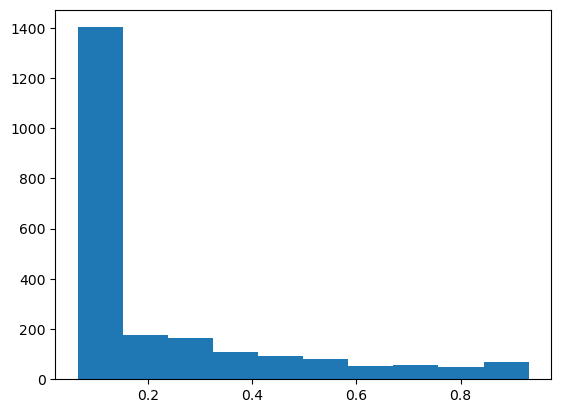

In [158]:
plt.hist(probs)

(array([ 44., 165., 357., 541., 704., 353.,  69.,   8.,   4.,   7.]),
 array([0.22996503, 0.28477222, 0.3395794 , 0.39438662, 0.4491938 ,
        0.504001  , 0.5588082 , 0.6136154 , 0.6684226 , 0.72322977,
        0.77803695], dtype=float32),
 <BarContainer object of 10 artists>)

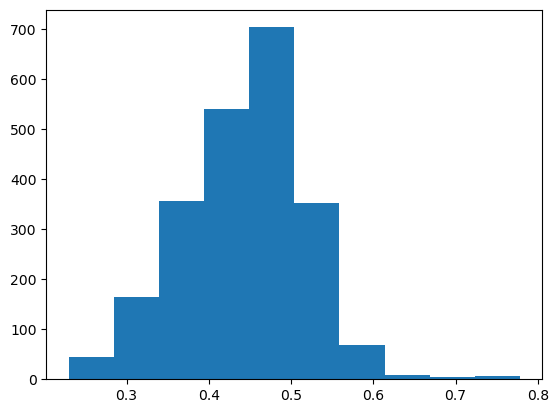

In [68]:
plt.hist(probs)

In [228]:
with torch.no_grad():

    loss_fct = FocalLoss(gamma=3, alpha=1, no_agg=True)
    loss = loss_fct(torch.tensor(preds).view(-1, 2), torch.tensor(labels).view(-1)).numpy()
    


In [229]:
loss.mean()

0.05588949

In [161]:
loss.mean()

0.16429487

In [162]:
predictions.metrics

{'test_loss': 0.4745558564340091,
 'test_runtime': 35.4366,
 'test_samples_per_second': 63.55,
 'test_steps_per_second': 0.254}

In [72]:
predictions.metrics

{'test_loss': 0.08382876757420506,
 'test_runtime': 34.2196,
 'test_samples_per_second': 65.81,
 'test_steps_per_second': 0.263}

In [230]:
weights = test_dataset.examples.weight

In [231]:
(weights * loss).mean()

0.13661413584668855

In [25]:
# weights / weights.sum()

In [75]:
loss.mean(), loss.std()

(0.030777544, 0.04567227)

(array([1704.,   45.,   23.,   15.,   11.,    7.,    2.,    7.,   11.,
           9.]),
 array([4.8576430e-06, 5.3740438e-02, 1.0747602e-01, 1.6121159e-01,
        2.1494718e-01, 2.6868275e-01, 3.2241833e-01, 3.7615392e-01,
        4.2988950e-01, 4.8362508e-01, 5.3736067e-01], dtype=float32),
 <BarContainer object of 10 artists>)

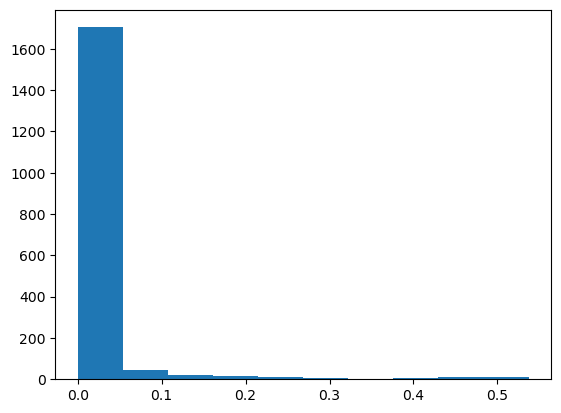

In [27]:
plt.hist(loss[labels==0])

(array([1270.,  514.,   45.,    3.,    0.,    0.,    0.,    0.,    0.,
           2.]),
 array([0.00079451, 0.01843849, 0.03608247, 0.05372646, 0.07137044,
        0.08901442, 0.10665841, 0.12430239, 0.14194638, 0.15959035,
        0.17723434], dtype=float32),
 <BarContainer object of 10 artists>)

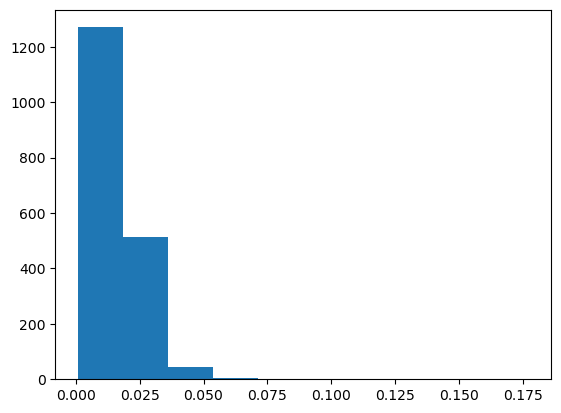

In [76]:
plt.hist(loss[labels==0])

(array([137.,  27.,  23.,  25.,   8.,  15.,  13.,   9.,  19., 142.]),
 array([1.7956590e-05, 1.6636607e-01, 3.3271420e-01, 4.9906230e-01,
        6.6541040e-01, 8.3175856e-01, 9.9810666e-01, 1.1644548e+00,
        1.3308029e+00, 1.4971510e+00, 1.6634991e+00], dtype=float32),
 <BarContainer object of 10 artists>)

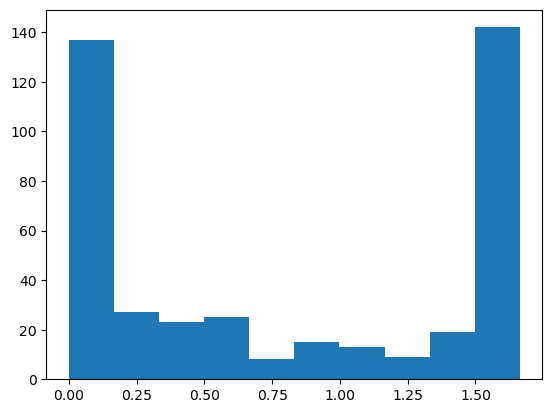

In [28]:
plt.hist(loss[labels==1])

(array([ 50., 199.,  88.,  36.,  20.,  11.,   8.,   1.,   4.,   1.]),
 array([0.00209222, 0.04754962, 0.09300703, 0.13846442, 0.18392183,
        0.22937922, 0.27483663, 0.32029402, 0.36575142, 0.41120884,
        0.45666623], dtype=float32),
 <BarContainer object of 10 artists>)

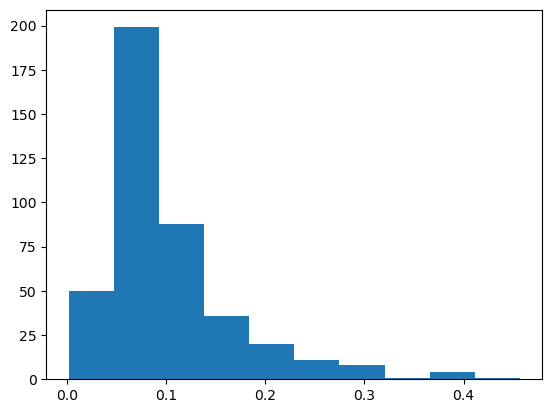

In [77]:
plt.hist(loss[labels==1])

In [165]:
roc_auc_score(labels, probs)

0.6223441584530376

In [79]:
X_train.groupby(['CDR3a_extended', 'CDR3b_extended']).y.agg('nunique').value_counts()

2    6719
1    1993
Name: y, dtype: int64

<AxesSubplot:>

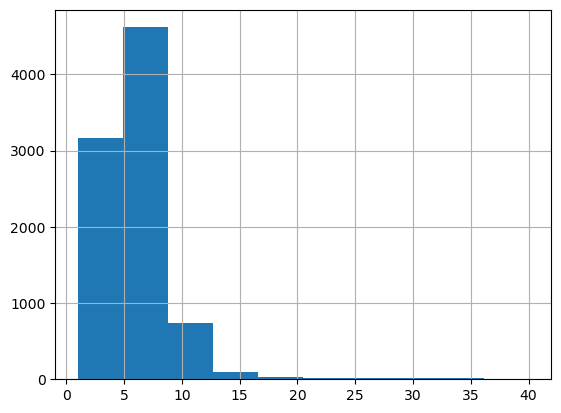

In [108]:
X_train.groupby(['CDR3a_extended', 'CDR3b_extended']).Peptide.agg('nunique').hist()

In [166]:
X_test.groupby(['CDR3a_extended', 'CDR3b_extended']).y.agg('nunique').value_counts()

1    869
2    142
Name: y, dtype: int64

In [167]:
amb = X_test.groupby(['CDR3a_extended', 'CDR3b_extended']).y.agg('nunique')
amb = amb[amb == 2]

In [168]:
multi_mask = pd.MultiIndex.from_frame(X_test[['CDR3a_extended', 'CDR3b_extended']]).isin(amb.index)

In [169]:
multi_mask.sum()

525

In [170]:
X_test.shape

(2252, 5)

In [85]:
# X_test.Peptide.value_counts()

<AxesSubplot:>

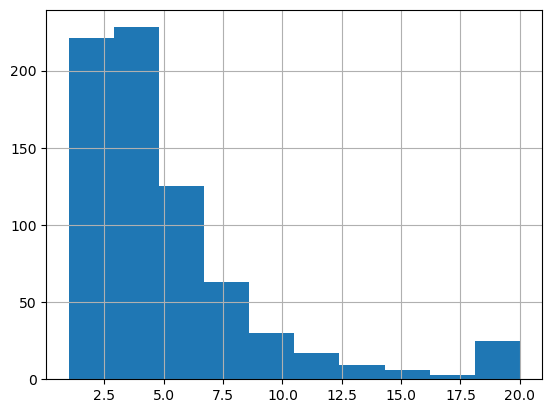

In [171]:
test_set.groupby(['CDR3a_extended', 'CDR3b_extended']).Peptide.agg('nunique').hist()

In [57]:
X_test.Peptide.value_counts()

GILGFVFTL      308
RAKFKQLL       294
IVTDFSVIK      258
NLVPMVATV      192
GLCTLVAML      162
YVLDHLIVV      126
SLLQHLIGL      120
YLQPRTFLL      120
TPRVTGGGAM     114
RPPIFIRRL      102
VTEHDTLLY      102
TIDDGIFEV       96
RPHERNGFTVL     90
MTLHGHMMY       84
QLLALLPSL       84
Name: Peptide, dtype: int64

<AxesSubplot:>

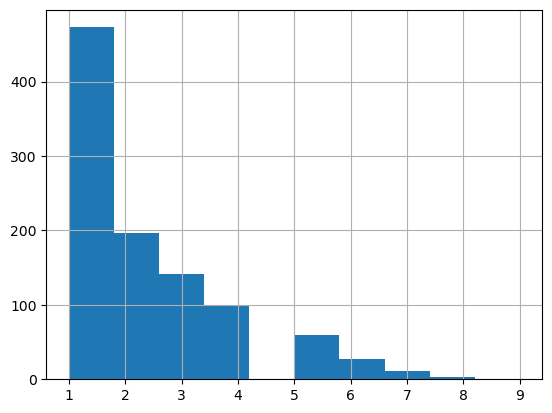

In [54]:
X_test.groupby(['CDR3a_extended', 'CDR3b_extended']).Peptide.agg('nunique').hist()

In [172]:
roc_auc_score(labels[multi_mask], probs[multi_mask])

0.47836762491934903

In [173]:
roc_auc_score(labels[~multi_mask], probs[~multi_mask])

0.6939589211723733

In [174]:
from bertrand.immrep.sample_test_set import train_sample_peps


In [175]:
test_iso_mask = (~test_dataset.examples.Peptide.isin(train_sample_peps))
roc_auc_score(labels[test_iso_mask], probs[test_iso_mask])

0.4859515570934256

In [176]:
(test_iso_mask& (~multi_mask)).sum()

368

In [177]:
roc_auc_score(labels[test_iso_mask& multi_mask], probs[test_iso_mask& multi_mask])

0.5067460317460317

In [178]:
roc_auc_score(labels[test_iso_mask& ~multi_mask], probs[test_iso_mask& ~multi_mask])

0.5531633616619452

In [179]:
test_iso_mask.sum()

510

In [180]:
pd.crosstab(test_iso_mask, multi_mask)

col_0,False,True
Peptide,,
False,1359,383
True,368,142


In [181]:
X_test[test_iso_mask].Peptide.value_counts()

YVLDHLIVV    126
SLLQHLIGL    120
TIDDGIFEV     96
MTLHGHMMY     84
QLLALLPSL     84
Name: Peptide, dtype: int64

In [182]:
pd.crosstab(X_test[test_iso_mask].Peptide, X_test[test_iso_mask].y)

y,0,1
Peptide,,
MTLHGHMMY,70,14
QLLALLPSL,70,14
SLLQHLIGL,100,20
TIDDGIFEV,80,16
YVLDHLIVV,105,21


In [113]:
amb_train  = X_train.groupby(['CDR3a_extended', 'CDR3b_extended']).y.agg('nunique')
amb_train = amb_train[amb_train == 2]

In [115]:
X_train.shape

(48730, 4)

In [116]:
amb_train.shape

(6719,)

In [126]:
amb_train.sample(4)

CDR3a_extended    CDR3b_extended     
CAASRGKGGGADGLTF  CASSYSTGTVDYEQYF       2
CAASIQYSNDYKLSF   CASSPSSGRVLYEQYF       2
CAVVGGYNKLIF      CASSPGQVSYEQYF         2
CVVSGKNTGFQKLVF   CASSVQALLAGDWADTQYF    2
Name: y, dtype: int64

In [127]:
X_train.query('CDR3a_extended == "CVVSGKNTGFQKLVF" and CDR3b_extended == "CASSVQALLAGDWADTQYF"')

,Peptide,CDR3b_extended,CDR3a_extended,y
5942,CLGGLLTMV,CASSVQALLAGDWADTQYF,CVVSGKNTGFQKLVF,0
8468,ELAGIGILTV,CASSVQALLAGDWADTQYF,CVVSGKNTGFQKLVF,0
25666,LLWNGPMAV,CASSVQALLAGDWADTQYF,CVVSGKNTGFQKLVF,0
38144,RLRAEAQVK,CASSVQALLAGDWADTQYF,CVVSGKNTGFQKLVF,0
40642,RPRGEVRFL,CASSVQALLAGDWADTQYF,CVVSGKNTGFQKLVF,1
49464,VTEHDTLLY,CASSVQALLAGDWADTQYF,CVVSGKNTGFQKLVF,0


In [218]:
row = amb.sample().reset_index().iloc[0]
row

CDR3a_extended       CAFMKHGNDMRF
CDR3b_extended    CASSRTGFNAYGYTF
y                               2
Name: 0, dtype: object

In [219]:
q = X_test.query(f'CDR3a_extended == "{row.CDR3a_extended}" and CDR3b_extended == "{row.CDR3b_extended}"')
q

,Peptide,CDR3a_extended,CDR3b_extended,y,weight
48,GILGFVFTL,CAFMKHGNDMRF,CASSRTGFNAYGYTF,0,1.586730
341,GLCTLVAML,CAFMKHGNDMRF,CASSRTGFNAYGYTF,0,1.784830
515,IVTDFSVIK,CAFMKHGNDMRF,CASSRTGFNAYGYTF,0,1.636920
1152,RAKFKQLL,CAFMKHGNDMRF,CASSRTGFNAYGYTF,0,1.599616
1721,TIDDGIFEV,CAFMKHGNDMRF,CASSRTGFNAYGYTF,1,1.985269
1929,VTEHDTLLY,CAFMKHGNDMRF,CASSRTGFNAYGYTF,0,1.959868
2032,YLQPRTFLL,CAFMKHGNDMRF,CASSRTGFNAYGYTF,0,1.894744


In [220]:
ind = q.index.values

In [221]:
ind

array([  48,  341,  515, 1152, 1721, 1929, 2032])

In [222]:
probs[ind]

array([0.07449862, 0.06732244, 0.06773889, 0.14603254, 0.06656772,
       0.11373109, 0.09789458], dtype=float32)

In [234]:
loss[ind].round(5)

array([3.0e-05, 2.0e-05, 2.0e-05, 4.9e-04, 0.0e+00, 1.8e-04, 1.0e-04],
      dtype=float32)

In [123]:
from bertrand.immrep.sample_train_set import filter_cdr, sample_additional

In [124]:
# def sample_train_additional(train, test, synthetic_test, T=10, seed=42, ratio=5, verbose=False):
train = train_set
test = test_set
synthetic_test = data_split['test_sample']
T=50
seed=42
verbose=True

np.random.seed(seed)
l = test.CDR3a_extended.str.len()
CDRA_MIN, CDRA_MAX = l.min(), l.max()
l = test.CDR3b_extended.str.len()
CDRB_MIN, CDRB_MAX = l.min(), l.max()
if verbose:
    print("len(CDR3a) in", [CDRA_MIN, CDRA_MAX], "len(CDR3b) in ", [CDRB_MIN, CDRB_MAX])

pos = train[["Peptide", "CDR3b_extended", "CDR3a_extended"]].drop_duplicates()
pos["y"] = 1

assert {pos.groupby(["Peptide", "CDR3b_extended", "CDR3a_extended"]).y.agg("count").max()} == {1}

additional_peptides = sample_additional(train, test, synthetic_test)
# if include_other_peptides:
pos = pos[pos.Peptide.isin(synthetic_test.Peptide) | pos.Peptide.isin(additional_peptides)]
# else:
# pos = pos[pos.Peptide.isin(test.Peptide)]
vc = pos["Peptide"].value_counts()
peps = vc.index[vc >= T]
pos = pos[pos.Peptide.isin(peps)]

la = pos.CDR3a_extended.str.len()
lb = pos.CDR3b_extended.str.len()
regex = f"[{''.join(AA_list)}]+"
pos = pos[
    (la >= CDRA_MIN)
    & (la <= CDRA_MAX)
    & (lb >= CDRB_MIN)
    & (lb <= CDRB_MAX)
    & (pos.CDR3a_extended.str[0] == "C")
    & (pos.CDR3b_extended.str[0] == "C")
    & pos.CDR3a_extended.str.fullmatch(regex)
    & pos.CDR3b_extended.str.fullmatch(regex)
]

pos_filt = filter_cdr(pos, synthetic_test)

# potential_tcr_negatives = (
#     pos_filt.groupby("Peptide")
#     .apply(lambda x: x.sample(frac=0.2) if len(x) >= 10 / 0.2 else x)
#     .reset_index(drop=True)
# )

potential_tcr_negatives = (
    pos_filt.groupby("Peptide")
    .apply(lambda x: x.sample(500) if len(x) >= 500 else x)
    .reset_index(drop=True)
)
# print(pos_filt.Peptide.value_counts())
# raise Exception()
if verbose:
    print(f"{len(pos)} positive observations total")
    print(f"{len(pos_filt)} positive observations filtered")
    print(f"{len(potential_tcr_negatives)} potential negatives  filtered")
    print(pos_filt.Peptide.value_counts())



len(CDR3a) in [7, 24] len(CDR3b) in  [9, 22]
17088 positive observations total
10656 positive observations filtered
8103 potential negatives  filtered
AVFDRKSDAK     2285
ELAGIGILTV      955
RLRAEAQVK       813
IVTDFSVIK       491
RLNAALREK       469
VVVGAVGVGK      389
GILGFVFTL       371
SPRWYFYYL       346
TTDPSFLGRY      337
HTMGFWLTK       302
NLVPMVATV       281
RAKFKQLL        268
KTYQGSYGFR      264
CINGVCWTV       230
LLWNGPMAV       220
SVMGVYVGK       215
YLQPRTFLL       189
LYVDSLFFL       184
GLCTLVAML       174
TPRVTGGGAM      161
FLRGRAYGL       159
RPPIFIRRL       148
VTEHDTLLY       141
ATDALMTGF       119
STLGNFWMK       113
RPHERNGFTVL     113
LTDEMIAQY       112
KTFPPTEPK        98
VVVGACGVGK       89
KSKRTPMGF        88
CLGGLLTMV        85
LLGRNSFEV        70
NQKLIANQF        66
AVASVPIMY        64
RPRGEVRFL        60
RAQAPPPSW        49
QYIKWPWYI        47
GPRLGVRAT        46
KLVALGINAV       45
Name: Peptide, dtype: int64


In [125]:
potential_tcr_negatives.shape

(8103, 4)

In [ ]:
rlist = []
plist = []
pos_filt_gb = pos_filt.groupby('Peptide')
for pep, pos_pep in pos_filt_gb:
    if len(pos_pep) < T:
        continue
    if len(pos_pep) > 500:
        pos_pep = pos_pep.sample(500).reset_index(drop=True)

    potential_negs = potential_tcr_negatives[potential_tcr_negatives.Peptide != pep]
    potential_negs_filt = filter_cdr(potential_negs, pos_pep, t=2).copy()

    if verbose:
        print(pep, len(pos_pep) * ratio, len(potential_negs), len(potential_negs_filt))
    if len(pos_pep) * ratio >= len(potential_negs_filt):
        neg_sample = potential_negs_filt.copy()
    else:
        neg_sample = potential_negs_filt.sample(len(pos_pep) * ratio)
    neg_sample["y"] = 0
    neg_sample["Peptide"] = pep
    rlist.append(neg_sample)
    plist.append(pos_pep)

df = pd.concat(plist+rlist)
df = df.groupby(["Peptide", "CDR3b_extended", "CDR3a_extended"]).y.max().reset_index()
assert {df.groupby(["Peptide", "CDR3b_extended", "CDR3a_extended"]).y.agg("nunique").max()} == {1}
# return df